<p style="font-family: Arial; font-size:1.75em;color:#003399; font-style:bold"><br>
 Segmentacja 
</p><br>
W ostatniej części pokazane zostaną sposoby wyodrębniania obiektów z obrazu oraz określanie ich charakterystyki

In [2]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_ubyte, img_as_float, img_as_int

** Ćwiczenie 1**<br>
Używając wybranego algorytmu typu BLOB policz ilość komórek Synechococcus sp.

In [5]:
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage import measure, util, exposure
import math

def radius(sigma):
    return(math.sqrt(2) * sigma)

chlorella = io.imread('Synechocystis_CCBA_UG.jpg', as_grey=True)
chl_inv = util.invert(chlorella)
pD = np.percentile(chl_inv,1)
pU = np.percentile(chl_inv,98)
foto = exposure.rescale_intensity(chl_inv,in_range=(pD, pU))


** Rozwiązanie 1**<br>

Ilość komórek: 365


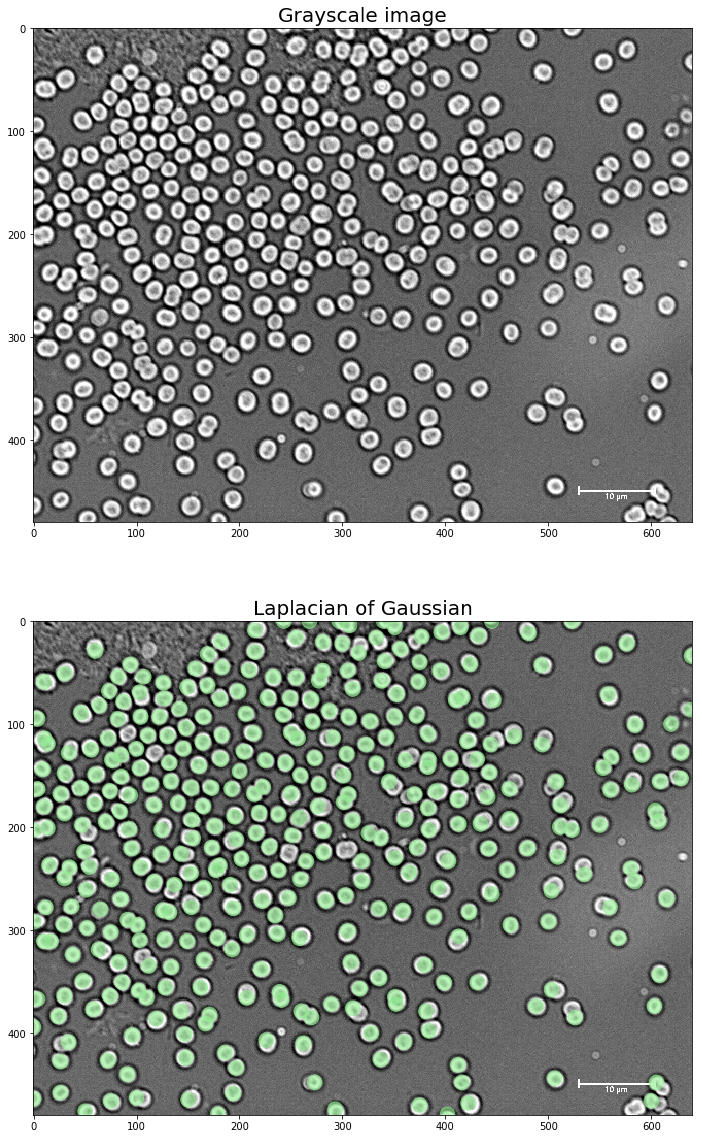

In [6]:
# blobs_log[row,column,sigma], gdzie promień = sqrt(2) * sigma
blobs_log = blob_log(foto, min_sigma=5, max_sigma=500)

# oblicz promień
if blobs_log.shape[0] > 0:
    blobs_log[:,2] = radius(blobs_log[:,2])

fig = plt.figure(figsize=(20,20))

ax3 = plt.subplot(211)
ax3.imshow(foto,cmap=plt.get_cmap('gray'))
ax3.set_title("Grayscale image",fontsize=20)

ax0 = plt.subplot(212)
ax0.imshow(foto,cmap=plt.get_cmap('gray'))
ax0.set_title('Laplacian of Gaussian',fontsize=20)
for b in blobs_log:
    O = plt.Circle((b[1], b[0]), b[2], color='lightgreen', fill=True, alpha=.6)#, linewidth=2) 
    ax0.add_patch(O)

print("Ilość komórek: %d"% len(blobs_log))

plt.show()


dodatkowo 7-28 komórek niewyodrębnionych

** Ćwiczenie 2**<br>
Policz ilość komórek Synechococcus sp. używając funkcji poniżej. Podaj ile komórek ma najbardziej zbliżony kształt do kuli (eccentricity komórki powinno być mniejsze niż 0.3)

In [37]:
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.filters import sobel, roberts, threshold_mean
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing
from matplotlib import colors

algae = io.imread('Synechocystis_CCBA_UG.jpg', as_grey=True)
chl_inv = util.invert(algae)
pD = np.percentile(chl_inv,1)
pU = np.percentile(chl_inv,98)
foto = exposure.rescale_intensity(chl_inv,in_range=(pD, pU))

** Rozwiązanie 2**<br>

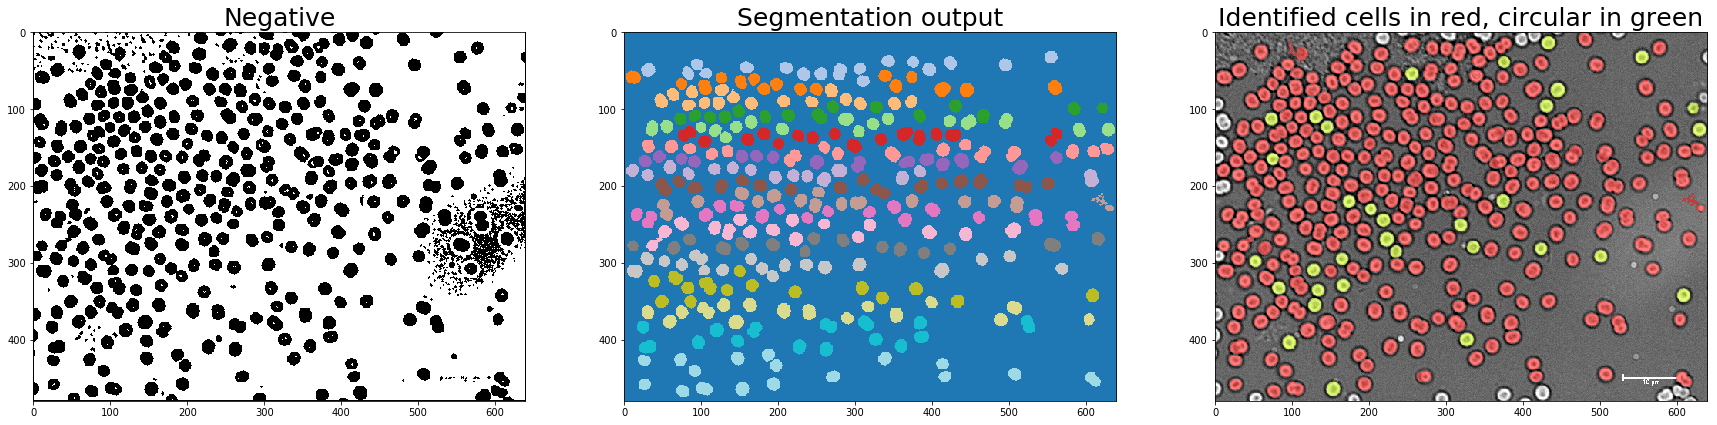

Zidentyfikowanych komórek: 307, okrągłych: 33, niezidentyfikowanych: 21


In [41]:
T = threshold_mean(foto)
bw = np.zeros_like(foto)
bw[foto < T] = 1

cm = colors.ListedColormap(["#FFFFFF00", '#FF000080', '#CCFF0080'])
edges = binary_closing(bw)
sfz = felzenszwalb(edges, scale=10, sigma=0.001, min_size=150)
circles = np.zeros_like(foto)

regions = sfz
label_img = label(regions)
all_properties = regionprops(label_img)

cells = 0
circular = 0
for region in all_properties:
    if region.label > 1:
        cells += 1
        if region.eccentricity < 0.3:
            circles[sfz == region.label] = 2
            circular += 1
        else:
            circles[sfz == region.label] = 1

# Draw them
fig = plt.figure(figsize=(30,30))
ax0 = plt.subplot(131)

ax0.imshow(edges,cmap=plt.get_cmap('gray'))
ax0.set_title("Negative",fontsize=25)

ax1 = plt.subplot(132)
ax1.imshow(label_img,cmap=plt.get_cmap('tab20'))
ax1.set_title("Segmentation output",fontsize=25)

ax2 = plt.subplot(133)
ax2.imshow(foto,cmap=plt.get_cmap('gray'))
ax2.imshow(circles,cmap=cm)
ax2.set_title("Identified cells in red, circular in green",fontsize=25)

plt.show()
# Dopisać ręcznie ilu komórek nie udało się zidentyfikować za pomoca algorytmu
missing = 21
print("Zidentyfikowanych komórek: %d, okrągłych: %d, niezidentyfikowanych: %d" % (cells,circular,missing))

** Ćwiczenie 3**<br>
Zastosuj poniższe filtry na zadjęciu mikroskopowym i podaj wartości PSNR oraz SSIM (przyjmij rozmiar okna 7x7) powstałych obrazów porównując je do obrazu początkowego. Który obraz charakteryzuje się najwyższym indeksem SSIM?

In [42]:
import numpy as np
from skimage.filters import gaussian, median
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet
from skimage.measure import compare_ssim, compare_psnr
from skimage import util 

def MSE(A, B):
     return(np.square(A - B).mean())

pD = np.percentile(chl_inv,1)
pU = np.percentile(chl_inv,98)
org = exposure.rescale_intensity(chl_inv,in_range=(pD, pU))

** Rozwiązanie 3**<br>

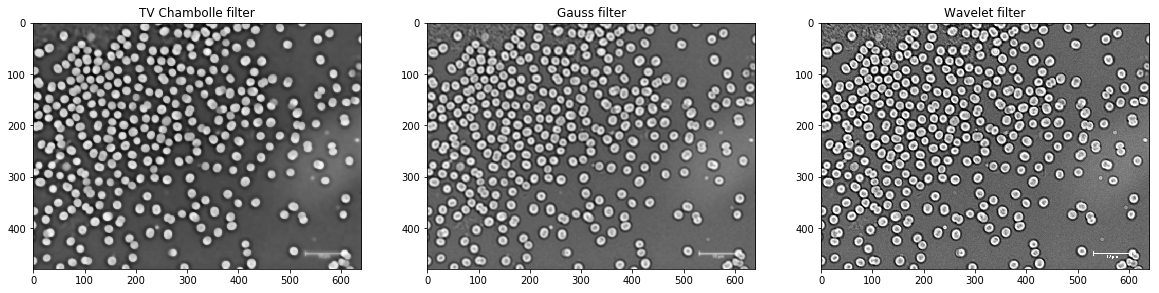

In [43]:
gauss = gaussian(org, sigma=1.5, preserve_range=True)
chambolle = denoise_tv_chambolle(org, weight=0.5, multichannel=False)
wavelet = denoise_wavelet(org, multichannel=False)

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(131)
ax1.imshow(chambolle,cmap=plt.get_cmap('gray'))
ax1.set_title("TV Chambolle filter")
ax2 = plt.subplot(132)
ax2.imshow(gauss,cmap=plt.get_cmap('gray'))
ax2.set_title("Gauss filter")
ax3 = plt.subplot(133)
ax3.imshow(wavelet,cmap=plt.get_cmap('gray'))
ax3.set_title("Wavelet filter")

plt.show()

In [44]:
#Oblicz SSIM (Structural Similarity Index)
ssim_chambolle = compare_ssim(org,chambolle,win_size=7,multichannel=False)
ssim_wavelet = compare_ssim(org,wavelet,win_size=7,multichannel=False)
ssim_gauss = compare_ssim(org,gauss,win_size=7,multichannel=False)

# Oblicz MSE (Mean Square Error)
MSE_chambolle = MSE(org,chambolle)
MSE_wavelet = MSE(org,wavelet)
MSE_gauss = MSE(org,gauss)

# Oblicz PSNR (Peak Signal to Noise Ratio)
psnr_chambolle = compare_psnr(org,chambolle)
psnr_wavelet = compare_psnr(org,wavelet)
psnr_gauss = compare_psnr(org,gauss)

print("TV Chambolle filter:\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_chambolle,ssim_chambolle,psnr_chambolle))
print("Gauss filter :\t\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_gauss,ssim_gauss,psnr_gauss))
print("Wavelet filter:\t\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_wavelet,ssim_wavelet,psnr_wavelet))

TV Chambolle filter:		MSE: 0.014, SSIM: 0.643, PSNR: 18.616
Gauss filter :			MSE: 0.007, SSIM: 0.821, PSNR: 21.753
Wavelet filter:			MSE: 0.000, SSIM: 0.973, PSNR: 34.074
